In [1]:
"""
   This section of the code simply sets up all possible variables we might want to change during training.
"""
import sys
import random
import numpy as np                     # Math and Deep Learning libraries
import torch                
from tqdm import tqdm                  # Pretty status bars
from collections import defaultdict

np.seterr(divide='ignore')             # Ignore divide by zero errors
np.warnings.filterwarnings('ignore')

# Use a GPU when possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load network architecture
from utils.model import Net

# Helper functions for running evaluation and visualization
from utils.analysis import *           

# Helper functions for converting strings to ints and sorting/padding data
from utils.data_processing import *

# Choose from configs.[bd, hco, nitro] or make your own
from configs.bd import config
config.device = device

# TESTING
# config.epochs = 1

## Data Preparation

In [2]:
###############################################################################
##    Infrastructure to process Data into Numpy Arrays of Integers
##    We convert letters to numbers via the acids dictionary.
##    We also compute the set of function labels (optionally training with binary)
###############################################################################
acids = {' ':0, 'A':1, 'C':2, 'E':3, 'D':4, 'G':5, 'F':6, 'I':7, 'H':8, \
         'K':9, 'M':10, 'L':11, 'N':12, 'Q':13, 'P':14, 'S':15, 'R':16, \
         'T':17, 'W':18, 'V':19, 'Y':20, 'X':21 }
config.input_dim = len(acids)
ints = {}
for v in acids:
    ints[acids[v]] = v

L = [line.strip() for line in open(config.labels,'r')]

# For logging we will store details of our training regime in the file name
run_name = pretty(config)

In [3]:
###############################################################################
##    If we are training a binary classifier, we need to resplit the data 
##    into chosen label vs OTHER
###############################################################################
lbls = {}    # Map label to integer
ilbls = {}   # Map integer back to label

# Perform Multiclass Classification
if config.binary is None:
    for v in L:
        lbls[v] = len(lbls)
        ilbls[lbls[v]] = v
    config.num_labels = len(lbls)
else:
    # Split dataset into one-vs-all
    for v in L:
        if v == config.binary:
            lbls[v] = 1
            ilbls[lbls[v]] = v
        else:
            lbls[v] = 0
            ilbls[lbls[v]] = "OTHER"
    print(lbls, ilbls)
    config.num_labels = 2
    run_name += "_" + config.binary

config.lbls = lbls
config.ilbls = ilbls

In [4]:
###############################################################################
##    Data is loaded, Train/Validation/Test, counted, converted to numbers and 
##    stored in numpy arrays.
###############################################################################
""" Data & Parameters """
data = [line.strip().split() for line in open(config.training,'r')]
val = [line.strip().split() for line in open(config.validation,'r')]

# Sanity check formatting of the input data
for vals in data:
    if len(vals) != 2:
        print("Problem: " + vals)
        sys.exit()

strs, inputs, outputs = process(data, acids, lbls)

print("Training counts\t")
l_c = defaultdict(int) 
for v in outputs:
    l_c[ilbls[v]] += 1
V = [(l_c[v],v) for v in l_c]
V.sort()
V.reverse()
print("    ".join(["{}: {}".format(lbl, cnt) for cnt,lbl in V]))

count = np.zeros(len(ilbls), dtype=np.float32)

for v in range(len(ilbls)):
    if ilbls[v] in l_c:
        count[v] += l_c[ilbls[v]]
distr = np.sum(count)/(np.size(count)*count) #1. - count/np.sum(count)
weight = torch.from_numpy(100*distr).to(device)

inps, outs, strs = sort_data(inputs, outputs, strs)
outs = np.array(outs)
strs = np.array(strs)

t_strs, t_inps, t_outs = process(val, acids, lbls)
t_inps, t_outs, t_strs = sort_data(t_inps, t_outs, t_strs)
t_outs = np.array(t_outs)
t_strs = np.array(t_strs)

print("Training    Inps: ", len(inputs))
print("Training    Outs: ", outputs.shape)
print("Validation  Inps: ", len(t_inps))
print("Validation  Outs: ", t_outs.shape)
print("Labels\t",lbls)

Training counts	
E1: 373    C: 206    E2: 123    A: 47    E4: 41    B: 33    E3: 26
Training    Inps:  849
Training    Outs:  (849,)
Validation  Inps:  117
Validation  Outs:  (117,)
Labels	 {'B': 0, 'E4': 1, 'E3': 2, 'E2': 3, 'C': 4, 'E1': 5, 'A': 6}


## Training

In [5]:
#torch.cuda.manual_seed(20180119)  <-- set a value for consistency
net = Net(config=config)
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

In [6]:
###############################################################################
##    Training Loop
###############################################################################
prev_acc = 0
for epoch in range(0, config.epochs + 1):

    batches = []
    indices = list(range(len(inps)))
    for start in range(0, len(indices), config.batch_size):
        batches.append((start, min(config.batch_size, len(indices)-start)))
    random.shuffle(batches)

    total_loss = 0.0
    train_acc = []
  
    net.reset_counts(epoch)
    for start, b_size in tqdm(batches, ncols=80):
        r = indices[start : start + b_size]
        
        # Setup
        optimizer.zero_grad()
        inputs = torch.from_numpy(pad_data(inps[indices[start] : indices[start+b_size-1] + 1])).to(device)
        labels = torch.from_numpy(outs[r]).to(device)

        # Predict
        net.train(mode=True)
        logits, att, full = net(inputs)
        ce_loss = net.loss(logits, labels, weight=weight)

        # Compute loss and update
        loss = ce_loss
        total_loss += ce_loss.item()
        loss.backward()
        optimizer.step()
    
        # Look at predictions
        _, preds = torch.max(logits, 1)
        dists = full.permute(0,2,1).cpu().data.numpy()
    
        preds = preds.data.cpu().numpy()
        np.add.at(net.pred_counts, preds, 1)
        np.add.at(net.gold_counts, outs[r], 1)
        np.add.at(net.corr_counts, preds[preds == outs[r]], 1)

        train_acc.extend(list(preds == outs[r]))
  
    # Evaluate on validation (during training)
    val_loss, val_acc = run_evaluation(net, t_inps, t_outs, t_strs, verbose=(epoch % 10 == 0 or epoch == config.epochs))

    print("Epoch: {}  Train Loss: {:8.4f}  Acc: {:5.2f}  Val  Loss {:8.4f}  Acc: {:5.2f}".format(epoch, 
          total_loss, 100*np.array(train_acc).mean(), val_loss, val_acc))

    # Save best validation model for optimal generalization
    if val_acc > prev_acc:
        prev_acc = val_acc
        pref = config.name
        torch.save(net, "{}.model".format(run_name))

out = torch.cat((net.embedding.weight.data, torch.ones(len(acids), 1).to(device)), 1)

  0%|                                                    | 0/27 [00:00<?, ?it/s]

E1         373   0.473 0.823 0.601   58    0.533 0.690 0.602
C          206   0.562 0.306 0.396   24    0.429 0.750 0.545
E2         123   0.089 0.041 0.056   17      nan 0.000   nan
A          47      nan 0.000   nan   6       nan 0.000   nan
E4         41      nan 0.000   nan   3       nan 0.000   nan
B          33    0.000 0.000   nan   1       nan 0.000   nan
E3         26      nan 0.000   nan   8       nan 0.000   nan
Epoch: 0  Train Loss:  45.7304  Acc: 44.17  Val  Loss   5.8410  Acc: 49.57


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]

E1         373   0.434 0.491 0.460   58    0.496 1.000 0.663
C          206   0.293 0.607 0.395   24      nan 0.000   nan
E2         123     nan 0.000   nan   17      nan 0.000   nan
A          47      nan 0.000   nan   6       nan 0.000   nan
E4         41      nan 0.000   nan   3       nan 0.000   nan
B          33      nan 0.000   nan   1       nan 0.000   nan
E3         26      nan 0.000   nan   8       nan 0.000   nan
Epoch: 1  Train Loss:  41.3035  Acc: 36.28  Val  Loss   5.2298  Acc: 49.57


Above is an example run of 100 epochs with training (left) and validation (right) precision, recall and F1 printed for every class.  Additionally, we print the overall  losses and accuracies after every epoch.  Note, these do not decrease monitonically but in general the model does perform better after some backtracking.  For most use cases a  shorter training regime is probably sufficient.

## Evaluation and Analysis

In [8]:
config.load = "1561246187_multi_BD_e1_h256_b32.model"
net = torch.load(config.load)                             # Load Saved Model
net.to(device)

# Run evaluation with best validation model on training
val = [line.strip().split() for line in open(config.training,'r')]
strs, inps, outs = process(val, acids, lbls)


config.confusion = True
config.pconfusion = False
loss, acc = run_evaluation(net, inps, outs, strs, aggregate=True, verbose=True)
print_predictors(net, "final")
print("Acc: {:5.3f}".format(acc))

100%|███████████████████████████████████████████| 27/27 [01:02<00:00,  2.31s/it]


E1         373   0.536 0.936 0.682   
C          206   0.793 0.762 0.777   
E2         123     nan 0.000   nan   
A          47      nan 0.000   nan   
E4         41      nan 0.000   nan   
B          33      nan 0.000   nan   
E3         26      nan 0.000   nan   
Acc: 59.600


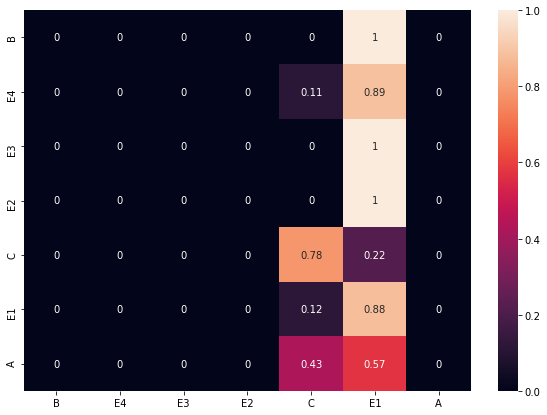

In [12]:
# Print confusion matrix on training data
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
data = [line.strip().replace("[","").replace("]","").split(",") for line in open("confusion.csv")]
labels = data[0][1:]
data = [[float(v) for v in line[1:-1]] for line in data[1:]]
df = pd.DataFrame(data, index = [i for i in labels], columns = [i for i in labels])
df_norm_col = df.div(df.sum(axis=1), axis=0)
plt.figure(figsize = (10,7))
_ = sn.heatmap(df_norm_col, annot=True)
plt.show()

In [10]:
# Run evaluation with best validation model on validation
val = [line.strip().split() for line in open(config.validation,'r')]
_, inps, outs = process(val, acids, lbls)

config.confusion = True
config.pconfusion = False
loss, acc = run_evaluation(net, inps, outs, showTrain=False, verbose=True)
print("Acc: {:5.3f}".format(acc))

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

E1         58    0.533 0.690 0.602   
C          24    0.429 0.750 0.545   
E2         17      nan 0.000   nan   
E3         8       nan 0.000   nan   
A          6       nan 0.000   nan   
E4         3       nan 0.000   nan   
B          1       nan 0.000   nan   
Acc: 49.573


In [11]:
# Run evaluation with best validation model on test
val = [line.strip().split() for line in open(config.testing,'r')]
_, inps, outs = process(val, acids, lbls)

loss, acc = run_evaluation(net, inps, outs, showTrain=False, verbose=True)
print("Acc: {:5.3f}".format(acc))

100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.23s/it]


E1         118   0.562 0.881 0.686   
C          51    0.625 0.784 0.696   
E2         33      nan 0.000   nan   
A          21      nan 0.000   nan   
E3         10      nan 0.000   nan   
E4         9       nan 0.000   nan   
B          7       nan 0.000   nan   
Acc: 57.831
